In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

columns = [
        # 'join_id',
        'dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        # ,'l2_num_raw_txs_per_day'
        ,'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
        ,'l1_gas_used_on_l2','calldata_bytes_l2_per_day','calldata_gas_l2_per_day'
        ,'l1_gas_used_user_txs_l2_per_day','calldata_bytes_user_txs_l2_per_day', 'calldata_gas_user_txs_l2_per_day'
        ,'l2_gas_used','l2_gas_used_user_txs_per_day','l2_eth_fees_per_day'
        ,'avg_l2_base_fee_gwei', 'avg_l2_gas_price_gwei'
        ]

In [2]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515_dt2023_09_21_180day.csv') #https://dune.com/queries/2453515
# goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn_dt2023_09_12.csv') #requires auth - https://dash.goldsky.com/question/9-op-chains-activity-by-period

In [3]:
# Map Chain Names
chain_mappings = {
    'zora': 'Zora Network',
    'pgn': 'Public Goods Network',
    # Add more mappings as needed
}
# goldskydf['chain'] = goldskydf['chain'].replace(chain_mappings)
dunedf['name'] = dunedf['name'].replace(chain_mappings)
dunedf['avg_l2_priority_fee_gwei'] = dunedf['avg_l2_gas_price_gwei'] - dunedf['avg_l2_base_fee_gwei']
dunedf['eth_fees_margin_per_day'] = dunedf['l2_eth_fees_per_day'] - dunedf['l1_eth_fees_combined']
# print(dunedf.columns)

added_cols = ['avg_l2_priority_fee_gwei','eth_fees_margin_per_day']

In [4]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
difference = set(columns) - set(dunedf.columns)
result = list(difference)

print(result)


[]


In [5]:
# Filter down to last X Days

dunedf['dt'] = pd.to_datetime(dunedf['dt'])

# Identify the most recent date in the dataset
most_recent_date = dunedf['dt'].max()

# Identify the date that is X days before the most recent date
date_X_days_ago = most_recent_date - pd.Timedelta(days=90)

print(len(dunedf))
# dunedf = dunedf[dunedf['dt'] > date_X_days_ago]
print(len(dunedf))

376
376


In [6]:
#Generate Join ID Column
# dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
# goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.copy()#merge(goldskydf, on='join_id', how='left')

# display(combo_df)

# for c in columns:
#         try:
#                 combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
#         except:
#                 combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns + added_cols]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']
combo_df['dt_rank'] = combo_df['dt'].rank(method='dense', ascending=False).astype('int')

In [7]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
40,2023-09-10 00:00:00+00:00,Base,86400.0,1462,24,90063416.0,9.732066,9.664176,9.672255,1.466979e+09,...,2.207091e+11,2.182659e+11,34.550279,1.066950e-02,0.081578,0.070909,20.253398,0.579607,0.658900,11
5,2023-09-19 00:00:00+00:00,OP Mainnet,86400.0,561,24,64802808.0,12.477871,11.372823,12.321089,1.045714e+09,...,2.210223e+11,2.187603e+11,37.426425,7.484021e-02,0.108926,0.034086,24.354431,0.648111,0.462225,2
306,2023-07-04 00:00:00+00:00,OP Mainnet,86400.0,745,23,80267497.0,24.875878,30.115807,23.862024,1.296384e+09,...,1.199421e+11,1.177303e+11,40.879088,7.901621e-08,0.049735,0.049735,8.570246,0.604136,0.431541,79
346,2023-06-21 00:00:00+00:00,Base,86400.0,1427,24,2036600.0,20.880912,19.600044,50.168704,6.233510e+07,...,2.170243e+09,2.100000e+04,0.000100,5.000000e-08,1.410000,1.410000,-1.342366,33227.665245,0.181321,92
84,2023-08-30 00:00:00+00:00,OP Mainnet,86400.0,726,24,84031209.0,22.978160,21.157551,22.744688,1.355758e+09,...,1.287023e+11,1.264804e+11,40.135636,1.325348e-07,0.061656,0.061656,8.938696,0.652250,0.471841,22


In [8]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_user_txs_l2_per_day'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_user_txs_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 62.4%
Blended bytes compression ratio: 52.5%


In [9]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='calldata_gas_user_txs_l2_per_day',#'l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'l2_num_txs_per_day',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_gas_user_txs_l2_per_day',#'calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'l2_num_txs_per_day',
                 color='chain',
                 title='Calldata Bytes on each Layer by chain')

fig_bytes.show()

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
0,2023-09-20 00:00:00+00:00,Base,86400.0,1636,24,97695315.0,13.618902,14.469367,13.151977,1.592186e+09,...,2.214014e+11,2.190348e+11,45.141098,2.508929e-02,0.087293,0.062204,23.427108,0.550451,0.687330,1
1,2023-09-20 00:00:00+00:00,OP Mainnet,86400.0,546,24,63073664.0,14.412632,13.808323,14.266173,1.017870e+09,...,2.214400e+11,2.191880e+11,34.961205,5.748633e-02,0.090088,0.032602,20.262237,0.652808,0.468939,1
4,2023-09-19 00:00:00+00:00,Base,86400.0,1667,24,115969659.0,13.057954,11.729401,13.204779,1.884226e+09,...,2.205269e+11,2.181187e+11,49.794793,1.037398e-02,0.081881,0.071507,25.166210,0.532910,0.644598,2
5,2023-09-19 00:00:00+00:00,OP Mainnet,86400.0,561,24,64802808.0,12.477871,11.372823,12.321089,1.045714e+09,...,2.210223e+11,2.187603e+11,37.426425,7.484021e-02,0.108926,0.034086,24.354431,0.648111,0.462225,2
6,2023-09-19 00:00:00+00:00,Zora Network,86400.0,148,24,10626024.0,12.395542,12.031223,12.069308,1.726257e+08,...,1.206355e+10,9.814225e+09,3.242639,5.002098e-08,0.145730,0.145730,1.077774,0.786297,0.431675,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2023-06-11 00:00:00+00:00,OP Mainnet,86400.0,698,24,75076007.0,17.448444,16.546322,17.139167,1.212501e+09,...,1.470628e+11,1.448317e+11,29.800585,4.947348e-07,0.042070,0.042070,8.609843,0.599574,0.425370,102
372,2023-06-10 00:00:00+00:00,OP Mainnet,86400.0,761,24,82801904.0,25.358090,22.331480,24.693872,1.337027e+09,...,1.885652e+11,1.863267e+11,60.743970,8.904987e-02,0.127894,0.038845,26.792971,0.611782,0.445716,103
373,2023-06-09 00:00:00+00:00,OP Mainnet,86400.0,725,24,78404424.0,21.023144,20.588342,20.835285,1.266183e+09,...,1.326059e+11,1.303807e+11,32.678976,2.305543e-07,0.023248,0.023248,6.016912,0.608638,0.442787,104
374,2023-06-08 00:00:00+00:00,OP Mainnet,86400.0,680,24,72779082.0,24.181462,23.095756,23.896230,1.175501e+09,...,1.154944e+11,1.132734e+11,36.827127,1.040016e-07,0.045787,0.045787,8.353655,0.607243,0.438044,105


In [10]:
new_data = combo_df[combo_df['active_secs_per_day'] == 86400].copy()
display(new_data.sample(5))

,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,l1_gas_used_inbox,...,l2_gas_used,l2_gas_used_user_txs_per_day,l2_eth_fees_per_day,avg_l2_base_fee_gwei,avg_l2_gas_price_gwei,avg_l2_priority_fee_gwei,eth_fees_margin_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
192,2023-08-03 00:00:00+00:00,OP Mainnet,86400.0,1173,24,132847327.0,23.126907,20.131147,23.004600,2.144107e+09,...,1.896759e+11,1.874399e+11,68.807141,3.228392e-03,0.068541,0.065313,19.178622,0.602894,0.426503,49
285,2023-07-11 00:00:00+00:00,Base,86400.0,1423,24,2297341.0,21.471210,19.525779,20.540101,6.641690e+07,...,2.304161e+09,1.337390e+08,0.567614,5.000000e-08,3.264626,3.264626,-0.899134,7.135715,0.194031,72
350,2023-06-20 00:00:00+00:00,Zora Network,86400.0,145,24,1875694.0,18.327914,16.966168,21.832888,3.300495e+07,...,2.188269e+09,1.414984e+07,0.026612,5.000000e-08,1.570573,1.570573,-0.613663,112.313683,0.166675,93
9,2023-09-18 00:00:00+00:00,OP Mainnet,86400.0,546,24,62864270.0,15.981227,15.227230,15.548883,1.014413e+09,...,2.211299e+11,2.188760e+11,56.276676,1.289215e-01,0.183470,0.054548,40.033375,0.669294,0.479210,3
64,2023-09-04 00:00:00+00:00,OP Mainnet,86400.0,542,24,62658748.0,15.629793,15.618428,15.406891,1.011123e+09,...,1.054205e+11,1.032060e+11,24.038639,1.011015e-07,0.070732,0.070732,8.202431,0.636583,0.456664,17


In [11]:
selected_columns = [
    'l2_num_txs_per_day' #, 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
    # , 'l1_gas_used_on_l2'
    , 'calldata_gas_l2_per_day'
    , 'calldata_bytes_l2_per_day'
    , 'l1_gas_used_user_txs_l2_per_day', 'calldata_bytes_user_txs_l2_per_day', 'calldata_gas_user_txs_l2_per_day'
    , 'l1_gas_used_inbox'
    , 'avg_l2_priority_fee_gwei', 'avg_l2_base_fee_gwei'
]

missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                     0
calldata_gas_l2_per_day                0
calldata_bytes_l2_per_day              0
l1_gas_used_user_txs_l2_per_day        0
calldata_bytes_user_txs_l2_per_day     0
calldata_gas_user_txs_l2_per_day       0
l1_gas_used_inbox                      0
avg_l2_priority_fee_gwei              12
avg_l2_base_fee_gwei                  12
dtype: int64

In [12]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.917606
calldata_gas_l2_per_day               0.975914
calldata_bytes_l2_per_day             0.971693
l1_gas_used_user_txs_l2_per_day       0.993936
calldata_bytes_user_txs_l2_per_day    0.971222
calldata_gas_user_txs_l2_per_day      0.975763
l1_gas_used_inbox                     1.000000
avg_l2_priority_fee_gwei             -0.372064
avg_l2_base_fee_gwei                  0.308359
Name: l1_gas_used_inbox, dtype: float64

In [13]:
# Filling the missing values in 'l1_gas_used_on_l2' with 0
# new_data['l1_gas_used_on_l2'].fillna(0, inplace=True)
new_data['calldata_gas_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_l2_per_day'].fillna(0, inplace=True)
new_data['l1_gas_used_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_gas_user_txs_l2_per_day'].fillna(0, inplace=True)


# Verifying that there are no more missing values in the selected columns
missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                     0
calldata_gas_l2_per_day                0
calldata_bytes_l2_per_day              0
l1_gas_used_user_txs_l2_per_day        0
calldata_bytes_user_txs_l2_per_day     0
calldata_gas_user_txs_l2_per_day       0
l1_gas_used_inbox                      0
avg_l2_priority_fee_gwei              12
avg_l2_base_fee_gwei                  12
dtype: int64

In [14]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.917606
calldata_gas_l2_per_day               0.975914
calldata_bytes_l2_per_day             0.971693
l1_gas_used_user_txs_l2_per_day       0.993936
calldata_bytes_user_txs_l2_per_day    0.971222
calldata_gas_user_txs_l2_per_day      0.975763
l1_gas_used_inbox                     1.000000
avg_l2_priority_fee_gwei             -0.372064
avg_l2_base_fee_gwei                  0.308359
Name: l1_gas_used_inbox, dtype: float64

In [15]:
# Build new values
new_data['l1_gas_used_per_user_tx'] = new_data['l1_gas_used_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['calldata_gas_per_user_tx'] = new_data['calldata_gas_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['calldata_bytes_per_user_tx'] = new_data['calldata_bytes_user_txs_l2_per_day'] / new_data['l2_num_txs_per_day']
new_data['l2_gas_used_per_user_tx'] = new_data['l2_gas_used_user_txs_per_day'] / new_data['l2_num_txs_per_day']

# display(new_data[new_data['l1_gas_used_user_txs_l2_per_day'] == 0].head(5))

new_data['l1_gas_used_per_user_tx'].fillna(0, inplace=True)
new_data['calldata_bytes_per_user_tx'].fillna(0, inplace=True)
new_data['calldata_gas_per_user_tx'].fillna(0, inplace=True)
new_data['l2_gas_used_per_user_tx'].fillna(0, inplace=True)

# new_data['l2_num_txs_per_day_sq'] = new_data['l2_num_txs_per_day'] ** 2

# display(new_data.head(5))

In [16]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Step 3: Data Splitting - Splitting the data into training and testing sets

# Selected features
features = [
    # 'l1_gas_used_user_txs_l2_per_day', 
    # 'calldata_bytes_user_txs_l2_per_day', 
    # 'calldata_gas_user_txs_l2_per_day',
    # 'l1_gas_used_per_user_tx',
    'calldata_bytes_per_user_tx',
    'calldata_gas_per_user_tx',
    'l2_num_txs_per_day', 
    # 'l2_gas_used_user_txs_per_day',
    # 'l2_num_txs_per_day_sq', 
    # 'l2_num_user_deposit_txs_per_day', 
    # 'l2_num_attr_deposit_txs_per_day'
]

# Target variable
target = 'l1_gas_used_inbox'

# Splitting the data into training and testing sets (80% training, 20% testing)
X = new_data[features]
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((296, 3), (74, 3))

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# print(X_train.isnull().sum())

# Step 4: Model Training - Training a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)


# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate the model performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_linear, r2_linear

(1.2806878151929749e+17, 0.8134026728205365)

In [18]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_


# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(2712375.865643263,
 {'calldata_bytes_per_user_tx': 799533.2455803093,
  'calldata_gas_per_user_tx': -53600.05693528113,
  'l2_num_txs_per_day': 2340.8672826934926})

In [19]:
from joblib import dump

# Save the model to a file
model_filepath = 'outputs/linear_regression_l1_gas_used_inbox_model.joblib'
dump(linear_regressor, model_filepath)


['outputs/linear_regression_l1_gas_used_inbox_model.joblib']

In [20]:
# Create a string to represent the regression equation
equation_str = f"l1_gas_used_inbox = {intercept:.2f}"
for feature, coef in feature_coeff_dict.items():
    equation_str += f" + ({coef:.2f}) * {feature}"

# Print out the regression equation
print(equation_str)

l1_gas_used_inbox = 2712375.87 + (799533.25) * calldata_bytes_per_user_tx + (-53600.06) * calldata_gas_per_user_tx + (2340.87) * l2_num_txs_per_day


In [21]:
# Group the data by 'chain' and calculate the weighted average values for each of the input features over the most recent 30 days
def weighted_average(group, col_name, wt_col):
    """Calculates the weighted average."""
    if col_name == wt_col:
        return group[col_name].mean()  # Simple average for 'l2_num_txs_per_day'
    else:
        return np.average(group[col_name], weights=group[wt_col])


In [22]:
# Find inputs
# Convert the 'dt' column to datetime data type
new_data['dt'] = pd.to_datetime(new_data['dt'])

# Identify the most recent date in the dataset
most_recent_date = new_data['dt'].max()

# Identify the date that is 30 days before the most recent date
date_30_days_ago = most_recent_date - pd.Timedelta(days=30)

# Filter the data to include only the most recent 30 days
recent_30_days_data = new_data[new_data['dt'] > date_30_days_ago]

print(features)
cols_to_avg = features + ['l2_gas_used_per_user_tx','avg_l2_base_fee_gwei', 'avg_l2_priority_fee_gwei'] + ['l1_eth_fees_combined','l2_eth_fees_per_day', 'eth_fees_margin_per_day'] + ['avg_l1_gas_price_on_l2']
# Group the data by 'chain' and calculate the average values for each of the input features over the most recent 30 days
# average_values_per_chain = recent_30_days_data.groupby('chain')[cols_to_avg].mean()

average_values_per_chain = recent_30_days_data.groupby('chain').apply(lambda g: pd.Series({
    col: weighted_average(g, col, wt_col = 'l2_num_txs_per_day') for col in cols_to_avg
}))


# Resetting the index to have 'chain' as a column
average_values_per_chain = average_values_per_chain.reset_index()

# Calculate the per transaction values for 'l1_gas_used_on_l2' and 'calldata_bytes_l2_per_day'
# average_values_per_chain['l1_gas_used_user_txs_on_l2_per_tx'] = average_values_per_chain['l1_gas_used_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']
# average_values_per_chain['calldata_bytes_user_txs_l2_per_tx'] = average_values_per_chain['calldata_bytes_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']

# Create a new DataFrame to hold the 'per_tx' values
average_values_per_chain = average_values_per_chain[['chain'
        ,'eth_fees_margin_per_day','l1_eth_fees_combined','l2_eth_fees_per_day','avg_l1_gas_price_on_l2'
        ,'l2_num_txs_per_day','avg_l2_base_fee_gwei', 'avg_l2_priority_fee_gwei', 'calldata_gas_per_user_tx', 'calldata_bytes_per_user_tx','l2_gas_used_per_user_tx']]


pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Display the average values per chain
display(average_values_per_chain)

['calldata_bytes_per_user_tx', 'calldata_gas_per_user_tx', 'l2_num_txs_per_day']


,chain,eth_fees_margin_per_day,l1_eth_fees_combined,l2_eth_fees_per_day,avg_l1_gas_price_on_l2,l2_num_txs_per_day,avg_l2_base_fee_gwei,avg_l2_priority_fee_gwei,calldata_gas_per_user_tx,calldata_bytes_per_user_tx,l2_gas_used_per_user_tx
0,Base,39.882,30.116,69.998,16.880,716742.300,0.057,0.111,1475.911,189.145,288321.586
1,OP Mainnet,15.545,23.529,39.074,17.622,339259.567,0.026,0.073,3487.582,423.835,415680.891
2,Public Goods Network,-0.305,0.908,0.603,18.016,521.414,0.000,1.336,7346.809,1046.107,145941.612
3,Zora Network,3.143,3.175,6.318,16.346,78217.517,0.000,0.290,1451.653,195.426,141065.308


/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_27082/2100537372.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_27082/2100537372.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_27082/2100537372.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

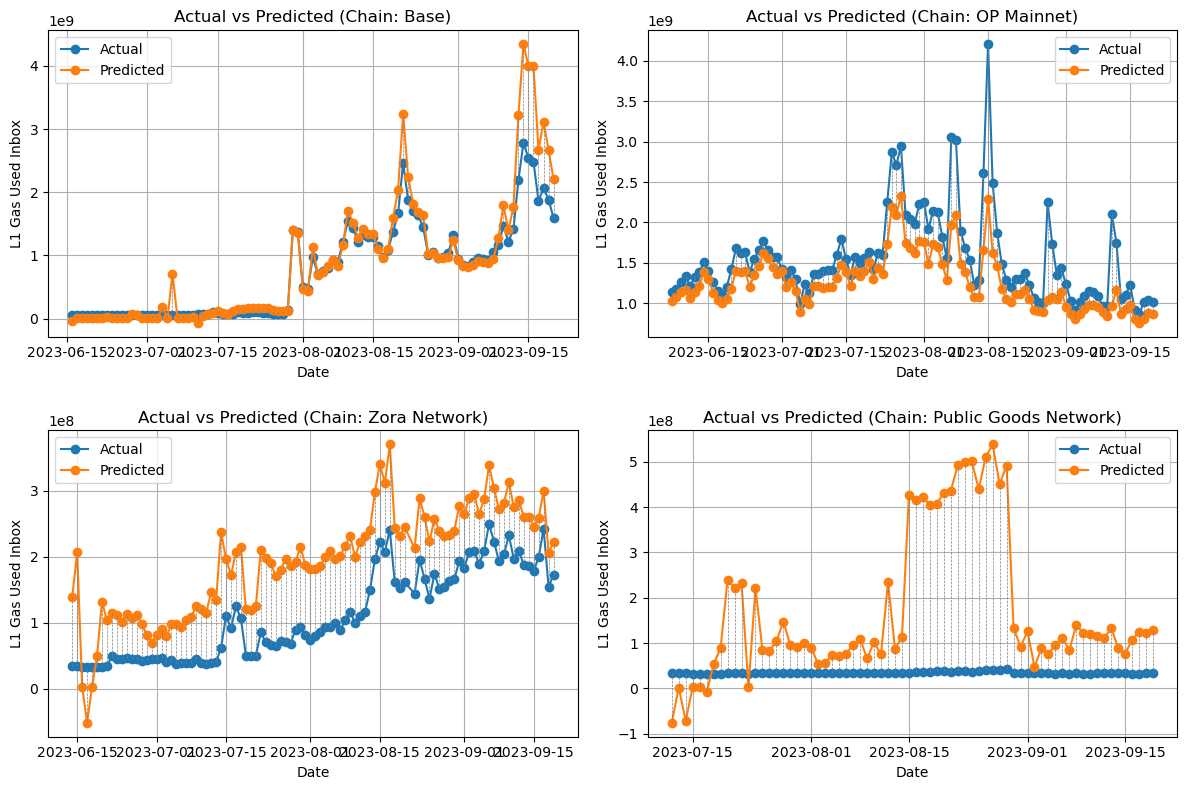

In [23]:
import matplotlib.pyplot as plt
# Setting up the plot
plt.figure(figsize=(12, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Making predictions using the new model
    chain_data['predicted_l1_gas_used_inbox_new'] = linear_regressor.predict(chain_data[features])
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_new'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox_new'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain})')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


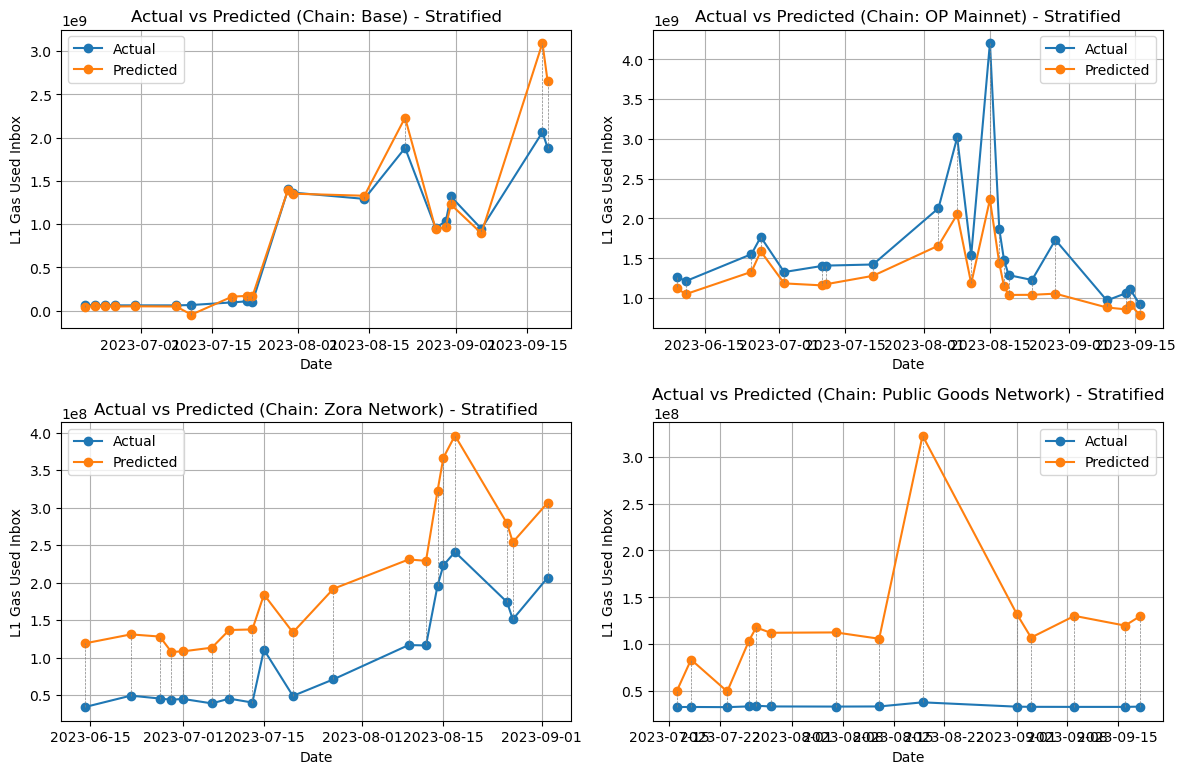

In [24]:
#Stratify sampling

from sklearn.model_selection import StratifiedShuffleSplit

# Resetting the index of new_data before performing stratified sampling
new_data.reset_index(drop=True, inplace=True)

# Defining the stratified shuffle split object to split the data into training and testing sets with stratification on the 'chain' column
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Splitting the data into training and testing sets using stratified sampling
for train_index, test_index in stratified_split.split(new_data, new_data['chain']):
    stratified_train_data = new_data.loc[train_index]
    stratified_test_data = new_data.loc[test_index]

# Training the linear regression model using the stratified training set
X_train_stratified = stratified_train_data[features]
y_train_stratified = stratified_train_data['l1_gas_used_inbox']
X_test_stratified = stratified_test_data[features]
y_test_stratified = stratified_test_data['l1_gas_used_inbox']

linear_regressor_stratified = LinearRegression()
linear_regressor_stratified.fit(X_train_stratified, y_train_stratified)

# Predicting the target variable on the stratified testing set
stratified_test_data['predicted_l1_gas_used_inbox'] = linear_regressor_stratified.predict(X_test_stratified)

# Setting up the plot for visualization of residuals for each chain
plt.figure(figsize=(12, 8))

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain and sorting it by date for a connected line plot
    chain_data = stratified_test_data[stratified_test_data['chain'] == chain].sort_values(by='dt')
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain}) - Stratified')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [25]:

# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_stratified = linear_regressor_stratified.predict(X_test_stratified)

# Calculate the model performance
mse_linear = mean_squared_error(y_test_stratified, y_pred_stratified)
r2_linear = r2_score(y_test_stratified, y_pred_stratified)

mse_linear, r2_linear


(1.1563396887115208e+17, 0.836444403090801)

In [26]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor_stratified.intercept_
coefficients = linear_regressor_stratified.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(49369200.40333974,
 {'calldata_bytes_per_user_tx': 544627.2330101855,
  'calldata_gas_per_user_tx': -36930.7766778758,
  'l2_num_txs_per_day': 2301.9155124570534})

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Step 1: Create second-degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(new_data[features])

# Step 2: Train a linear regression model using the polynomial features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, new_data['l1_gas_used_inbox'])

# Step 3: Make predictions using the polynomial features
new_data['predicted_l1_gas_used_inbox_poly'] = poly_lr.predict(X_poly)

# Step 4: Evaluate the model using suitable metrics
mse_poly = mean_squared_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
mae_poly = mean_absolute_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
r2_poly = r2_score(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])

mse_poly, mae_poly, r2_poly


(2023496732243411.0, 24920005.51309743, 0.9966685840372511)

In [28]:
# Get feature names
feature_names = poly.get_feature_names_out(input_features=features)

# Get the coefficients and intercept of the model
coef = poly_lr.coef_
intercept = poly_lr.intercept_

# Print out the model
print("Polynomial regression model:")
print("")
print(f"Intercept: {intercept}")
for i in range(len(coef)):
    print(f"{feature_names[i]}: {coef[i]}")

print("")
print("^ Input this output in to GPT to generate a python / google sheets apps script function")
print("Note: This seems like the best, lets yolo use it")

Polynomial regression model:

Intercept: 36072092.42860007
calldata_bytes_per_user_tx: -3716.8613013091917
calldata_gas_per_user_tx: 91.97592357479029
l2_num_txs_per_day: 1326.8156406251255
calldata_bytes_per_user_tx^2: 12.794672518158018
calldata_bytes_per_user_tx calldata_gas_per_user_tx: -2.093033664012317
calldata_bytes_per_user_tx l2_num_txs_per_day: -6.322923102546262
calldata_gas_per_user_tx^2: 0.08588471077448556
calldata_gas_per_user_tx l2_num_txs_per_day: 1.3786867756176369
l2_num_txs_per_day^2: -0.00023124255145035022

^ Input this output in to GPT to generate a python / google sheets apps script function
Note: This seems like the best, lets yolo use it


In [29]:
# # Get averages
# print(features)
# columns_to_average = features + ['l2_gas_used_per_user_tx']
# display(new_data.groupby('chain')[columns_to_average].mean())

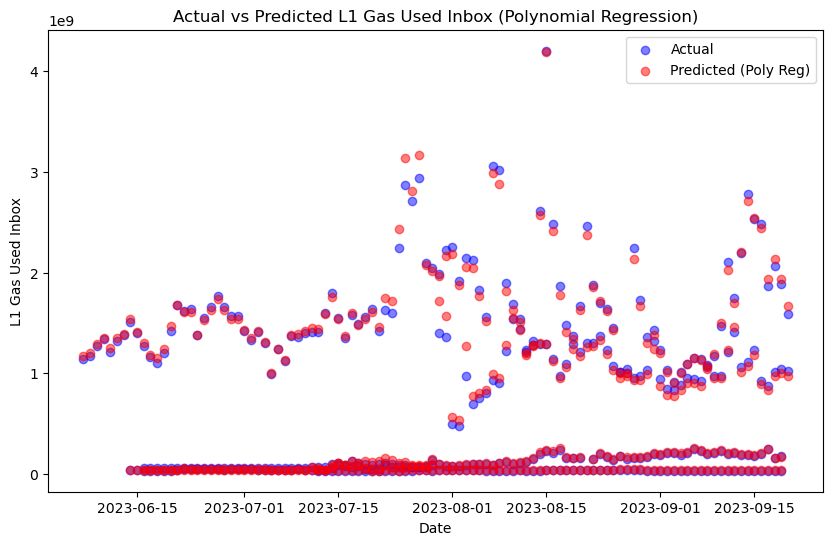

In [30]:
# Visualizing the actual vs predicted values for the model with polynomial features
plt.figure(figsize=(10, 6))

# Plotting the actual values
plt.scatter(new_data['dt'], new_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')

# Plotting the predicted values from the polynomial regression model
plt.scatter(new_data['dt'], new_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')

# Labeling the axes and setting the title
plt.xlabel('Date')
plt.ylabel('L1 Gas Used Inbox')
plt.title('Actual vs Predicted L1 Gas Used Inbox (Polynomial Regression)')

# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()


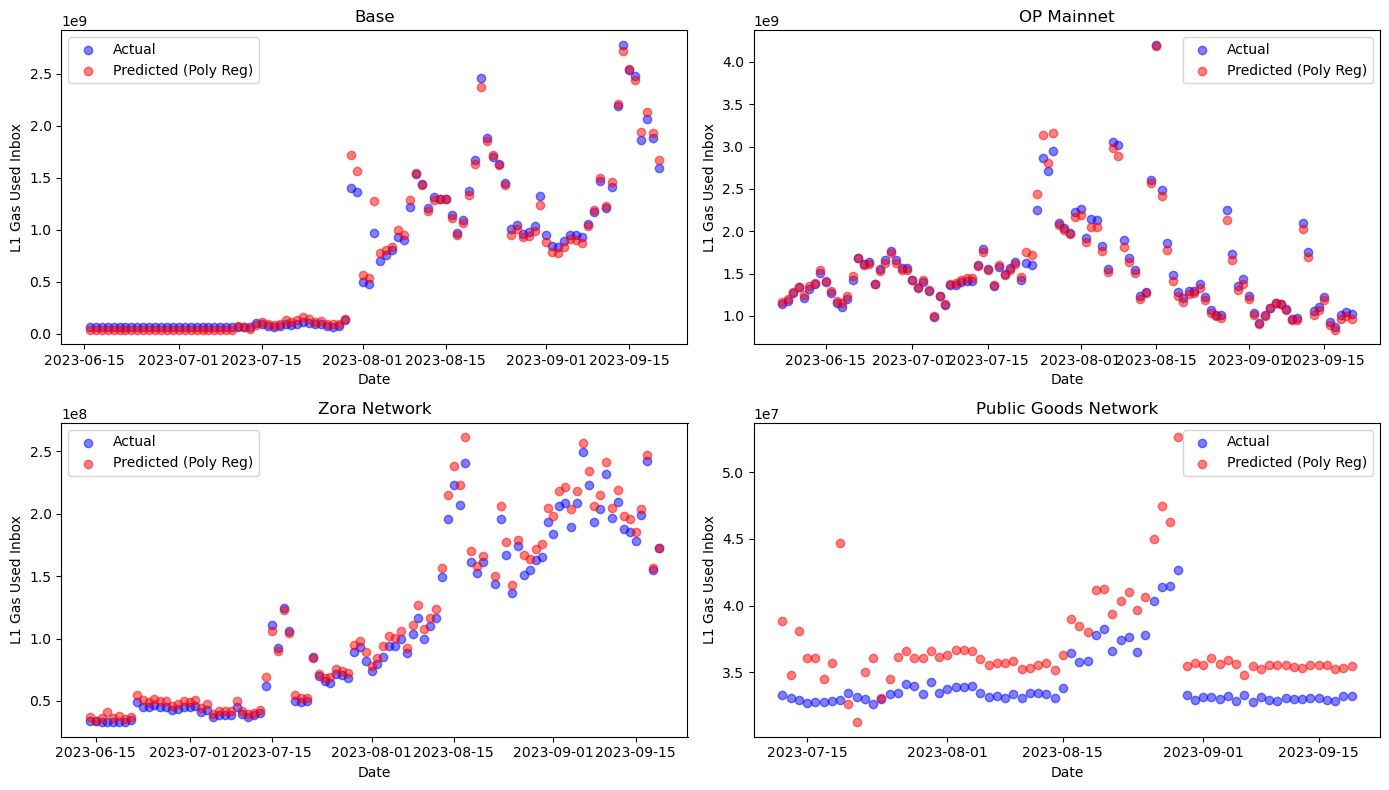

In [31]:
# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [32]:
#Linear Interactions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming new_data and features are defined
# features should be a list of column names that you want to use as features

X = new_data[features]
y = new_data['l1_gas_used_inbox']

# Create interaction features without polynomial terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Train a linear regression model using the interaction features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, y)

# Print the coefficients (intercept and slopes)
print('Intercept:', poly_lr.intercept_)
for i, coef in enumerate(poly_lr.coef_):
    print(f'Coefficient for {poly.get_feature_names_out(X.columns)[i]}: {coef}')

# Predict the target variable using the trained model
y_pred = poly_lr.predict(X_poly)

# Evaluate the model using R-squared
print('R-squared:', r2_score(y, y_pred))


Intercept: 55076531.33842063
Coefficient for calldata_bytes_per_user_tx: -15712.846427807392
Coefficient for calldata_gas_per_user_tx: 76.70831980398889
Coefficient for l2_num_txs_per_day: 952.7264202901692
Coefficient for calldata_bytes_per_user_tx calldata_gas_per_user_tx: 0.1408605661769471
Coefficient for calldata_bytes_per_user_tx l2_num_txs_per_day: -5.665869011483973
Coefficient for calldata_gas_per_user_tx l2_num_txs_per_day: 1.3588254225656584
R-squared: 0.9953315478699724


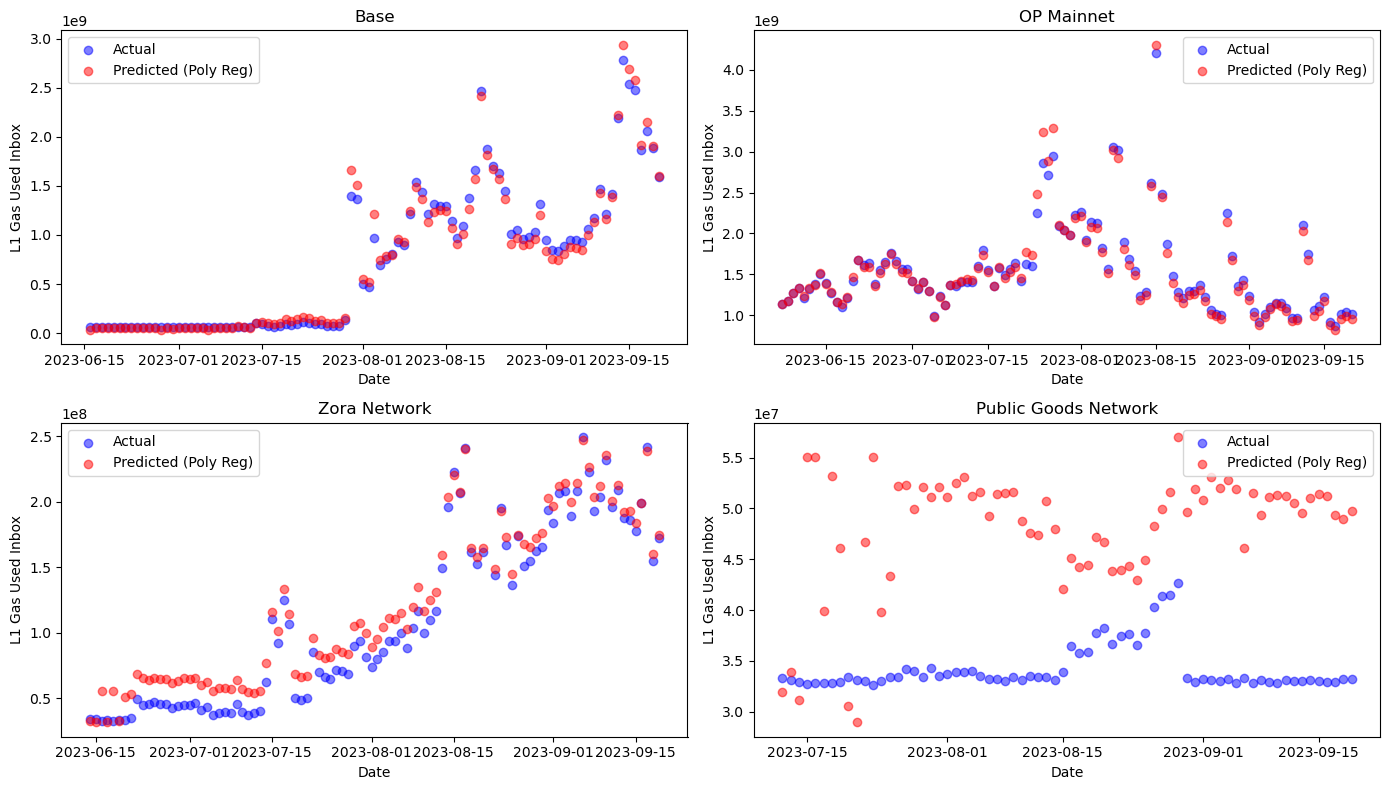

In [33]:
new_data['predicted_l1_gas_used_inbox_poly'] = y_pred

import matplotlib.pyplot as plt

# Adding a column to store the predicted values
new_data['predicted_l1_gas_used_inbox_poly'] = y_pred

# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [34]:
# Divide the continuous target variable into bins using qcut and get the bin intervals
new_data['l1_gas_used_inbox_intervals'], bins_intervals = pd.qcut(new_data['l1_gas_used_inbox'], q=5, retbins=True, precision=0)

# Convert bin intervals to labels
bin_labels = [f"{int(bins_intervals[i])} to {int(bins_intervals[i+1])}" for i in range(len(bins_intervals)-1)]

# Assign labels to your data
new_data['l1_gas_used_inbox_binned'] = pd.cut(new_data['l1_gas_used_inbox'], bins=bins_intervals, labels=bin_labels, include_lowest=True)

# Split data and also retrieve the indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_poly,
                                                                        new_data['l1_gas_used_inbox'],
                                                                        new_data.index,  # This will return the indices
                                                                        test_size=0.2, 
                                                                        stratify=new_data['l1_gas_used_inbox_intervals'])

# Train the model
poly_lr = LinearRegression().fit(X_train, y_train)

# Predict the target variable using the trained model for the test set
y_pred = poly_lr.predict(X_test)

# Construct the DataFrame with predictions for test set
test_data = pd.DataFrame({'X_test_index': idx_test, 'predicted_l1_gas_used_inbox_poly_strat': y_pred})
new_data = pd.merge(new_data, test_data, left_index=True, right_on='X_test_index', how='left')

# Make predictions for the entire dataset for plotting
new_data['predictions'] = poly_lr.predict(X_poly)

# Print the coefficients (intercept and slopes)
print('Intercept:', poly_lr.intercept_)
for i, coef in enumerate(poly_lr.coef_):
    print(f'Coefficient for {poly.get_feature_names_out(X.columns)[i]}: {coef}')

# Evaluate the model using R-squared
print('R-squared:', r2_score(y_test, y_pred))

# Metrics
mse_poly = mean_squared_error(y_test, y_pred)
mae_poly = mean_absolute_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred)

print(mse_poly, mae_poly, r2_poly)

Intercept: 55466224.6393199
Coefficient for calldata_bytes_per_user_tx: -12404.194821879097
Coefficient for calldata_gas_per_user_tx: -167.81428438628
Coefficient for l2_num_txs_per_day: 939.0834244821773
Coefficient for calldata_bytes_per_user_tx calldata_gas_per_user_tx: 0.14751707139699022
Coefficient for calldata_bytes_per_user_tx l2_num_txs_per_day: -5.663568254708409
Coefficient for calldata_gas_per_user_tx l2_num_txs_per_day: 1.3580987383384127
R-squared: 0.9956078886829458
2106454774680126.8 34125960.17106487 0.9956078886829458


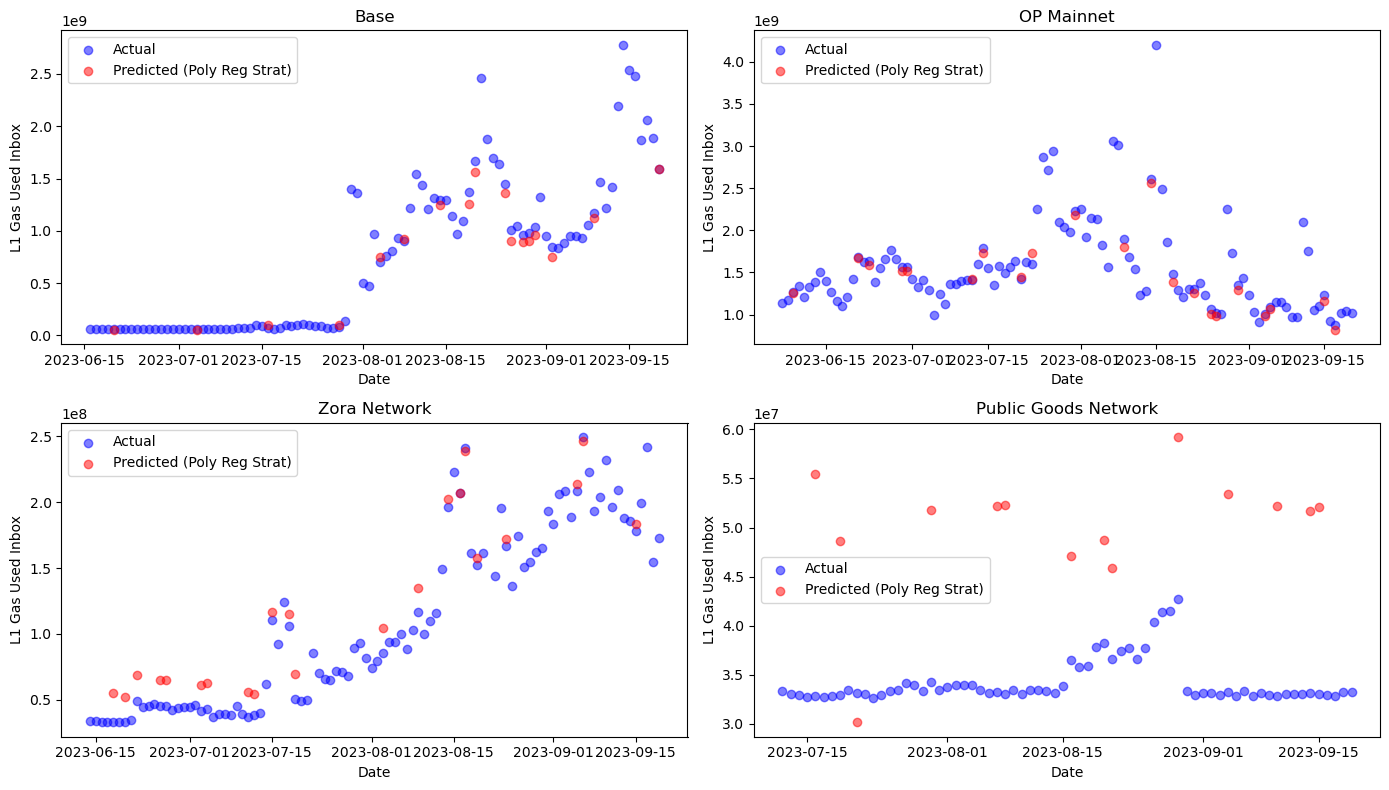

In [35]:
import matplotlib.pyplot as plt

# Adding a column to store the predicted values
# new_data['predicted_l1_gas_used_inbox_poly_strat'] = y_pred

# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly_strat'], label='Predicted (Poly Reg Strat)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


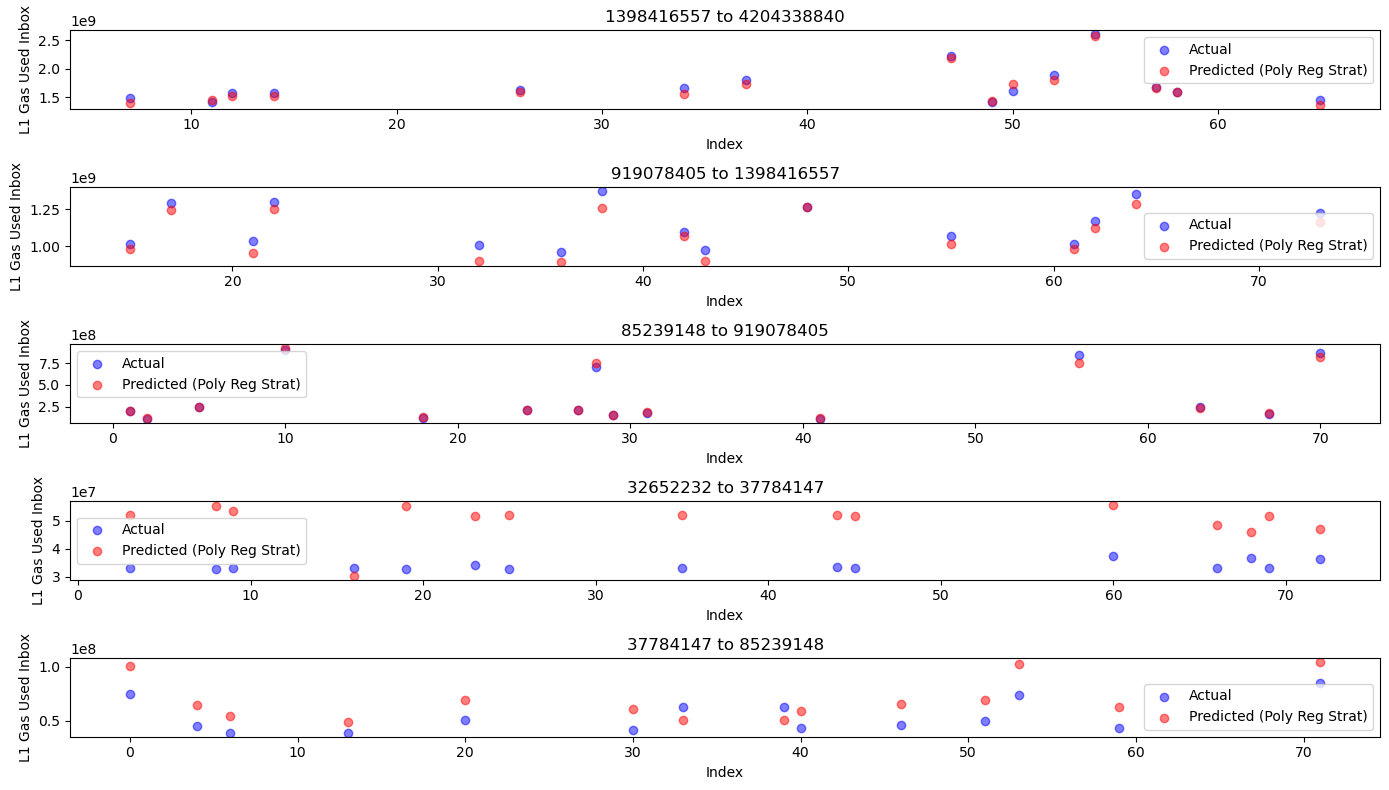

In [36]:
import matplotlib.pyplot as plt

# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique bins
bins_list = new_data['l1_gas_used_inbox_binned'].unique()

# Plotting the actual and predicted values for each bin in separate subplots
for i, bin_interval in enumerate(bins_list, 1):
    plt.subplot(len(bins_list), 1, i)
    
    # Filtering the data for the current bin
    bin_data = new_data[new_data['l1_gas_used_inbox_binned'] == bin_interval]
    
    # Plotting the actual values
    plt.scatter(bin_data.index, bin_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(bin_data.index, bin_data['predicted_l1_gas_used_inbox_poly_strat'], label='Predicted (Poly Reg Strat)', alpha=0.5, color='red')
    
    # Setting the title to the current bin interval
    plt.title(bin_interval)
    
    # Labeling the axes
    plt.xlabel('Index')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()
